# **Modelling for a real world dataset to obtain Insights and Recommendation**


## **Business Problem Statement**
**Objective:**   
The aim of this project is to examine the energy performance of residential buildings in Ireland using machine learning techniques, particularly clustering and classification. Data-driven decision-making for sustainable investments and retrofitting is supported by the project's ability to anticipate CO₂ emission classes and identify insulating patterns.

**Business Issue:**  
Concern over energy efficiency is rising in Ireland's property market. Investors and sustainability experts require effective methods for determining which buildings use energy efficiently. Manual audits take a lot of time and money. Prioritizing retrofitting and green investment initiatives can be aided by a scalable solution that makes use of the building data that is currently accessible.  

**Dataset Description:**  
The Building Energy Rating (BER) dataset from the Sustainable Energy Authority of Ireland (SEAI) is used in this project (https://ndber.seai.ie/BERResearchTool/ber/search.aspx).  
Comprehensive details about residential homes are included, such as:  
- Year of Construction  
- CO₂ emission  
- Space and water heating fuel types  
- U-values for walls, roof, windows, and doors   
- Energy rating (A1–G)  

**Modelling Approach:**  
 **Clustering (Unsupervised):** Used to identify segments based on natural efficiency by grouping buildings according to comparable structural and insulating characteristics.  
**Classification (Supervised):** Based on known inputs like fuel type, insulation, and construction year, it may predict a building's carbon emission category (Low, Medium, or High).


## **Setting Up Google Colab Environment**
To ensure that all required Python libraries are installed for our analysis we install the following libraries:

In [ ]:
pip install pandas matplotlib seaborn

## **Data Loading and Initial Preparation**
The dataset was filtered to only contain buildings built in 2000 or after to ensure relevance with modern construction norms. This choice is in line with the business objective of examining current trends in energy efficiency and assisting with green investment choices.

In [ ]:
# Import Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


print("All libraries are correctly installed and loaded")

All libraries are correctly installed and loaded


### Load Dataset

The Building Energy Rating (BER) dataset is loaded using a **relative path**. This ensures that the code remains portable and will work as long as the dataset file (`BER_15_Variables_Cleaned.csv`) is placed in the **same directory** as this notebook.

In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv("BER_15_Variables_Cleaned.csv")

# Filter dataset for buildings constructed from the year 2000
ber_dataset = df[df["Year_of_Construction"] >= 2000]

# View cleaned dataset
print("Original dataset shape:", df.shape)
print("Filtered dataset shape (Year >= 2000):", ber_dataset.shape)
ber_dataset.head()

Original dataset shape: (99999, 15)
Filtered dataset shape (Year >= 2000): (38538, 15)


,EnergyRating,BerRating,CO2Rating,CountyName,Year_of_Construction,DwellingTypeDescr,MainSpaceHeatingFuel,MainWaterHeatingFuel,SHRenewableResources,WHRenewableResources,UValueWall,UValueRoof,UValueWindow,UvalueDoor,HSMainSystemEfficiency
0,C2,196.70,36.77,Dublin 11,2003,Top-floor apartment,NaN,NaN,NaN,NaN,0.50,0.26,2.8,3.00,NaN
1,C3,212.81,39.87,Co. Cork,2000,Semi-detached house,Mains Gas,Mains Gas,2.0,2.0,0.55,0.40,2.8,2.77,78.4
2,C3,210.95,39.41,Dublin 11,2003,Top-floor apartment,NaN,NaN,NaN,NaN,0.50,0.26,2.8,3.00,NaN
3,C3,221.90,41.44,Dublin 11,2003,Top-floor apartment,NaN,NaN,NaN,NaN,0.51,0.26,2.8,3.00,NaN
8,D1,250.46,52.77,Co. Dublin,2000,Mid-terrace house,Mains Gas,Mains Gas,2.0,2.0,0.55,0.36,4.8,3.45,83.0


## **Data Preprocessing**
The dataset was cleaned using a number of techniques in order to get it ready for analysis.  
Dropped columns with more than 50% missing values to ensure data reliability

Removed rows containing remaining null values to avoid issues during modelling

Eliminated duplicate records to maintain data integrity

Standardized column names by converting them to lowercase and replacing spaces and hyphens with underscores for consistency.

These preprocessing steps ensured that the dataset was clean, consistent, and suitable for feature engineering, exploratory analysis, and machine learning models.


In [ ]:
# Check for missing values
missing_values = ber_dataset.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Drop columns with more than 50% nulls
threshold = len(ber_dataset) * 0.5
ber_dataset = ber_dataset.dropna(thresh=threshold, axis=1)

# Drop rows with remaining null values
ber_dataset = ber_dataset.dropna()

# Drop duplicates
ber_dataset = ber_dataset.drop_duplicates()

# Clean column names
ber_dataset.columns = (
    ber_dataset.columns.str.strip()
                        .str.lower()
                        .str.replace(" ", "_")
                        .str.replace("-", "_")
)

# Check structure
print("\nCleaned dataset shape:", ber_dataset.shape)
ber_dataset.info()
print(ber_dataset.columns.tolist())


Missing values in each column:
 EnergyRating                0
BerRating                   0
CO2Rating                   0
CountyName                  0
Year_of_Construction        0
DwellingTypeDescr           0
MainSpaceHeatingFuel      853
MainWaterHeatingFuel      853
SHRenewableResources      853
WHRenewableResources      853
UValueWall                  0
UValueRoof                  0
UValueWindow                0
UvalueDoor                  0
HSMainSystemEfficiency    853
dtype: int64

Cleaned dataset shape: (35722, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 35722 entries, 1 to 99998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   energyrating            35722 non-null  object 
 1   berrating               35722 non-null  float64
 2   co2rating               35722 non-null  float64
 3   countyname              35722 non-null  object 
 4   year_of_construction    35722 non-null  in

## **Label Creation**
Two categorical labels were created from existing variables to support classification:

rating_class: Simplified BER ratings (A1–G) into three categories:

High (A1–A3), Medium (B1–C3), Low (D–G)

co2_class: Derived from co2rating to classify carbon emissions:

Low (≤30), Medium (31–60), High (>60)

The co2_class label was used as the target variable for the classification model. This label allows us to build classification models that can predict whether a building belongs to a low, medium, or high carbon emission class based on its structural and heating attributes.



In [ ]:
# Classify BER energy rating to 3 classes
def simplify_rating(rating):
    if rating in ["A1", "A2", "A3"]:
        return "High"
    elif rating in ["B1", "B2", "B3", "C1", "C2", "C3"]:
        return "Medium"
    else:
        return "Low"

ber_dataset["rating_class"] = ber_dataset["energyrating"].apply(simplify_rating)
ber_dataset[["energyrating", "rating_class"]].head()


,energyrating,rating_class
1,C3,Medium
8,D1,Low
17,E2,Low
18,E2,Low
20,B3,Medium


In [ ]:
# Show distribution of the classes
ber_dataset["rating_class"].value_counts()


,count
rating_class,
Medium,27847
Low,7061
High,814


In [ ]:
# Classify CO₂ emissions into 3 categories
def classify_co2(value):
    if value <= 30:
        return "Low"
    elif value <= 60:
        return "Medium"
    else:
        return "High"

# Apply the classification to create a new column
ber_dataset["co2_class"] = ber_dataset["co2rating"].apply(classify_co2)

# Display results
print(ber_dataset[["co2rating", "co2_class"]].head())

# Show distribution of the classes
ber_dataset["co2_class"].value_counts()


    co2rating co2_class
1       39.87    Medium
8       52.77    Medium
17      76.70      High
18      83.28      High
20      28.68       Low


,count
co2_class,
Medium,23050
Low,7969
High,4703


## **Exploratory Data Analysis (EDA)**
Exploratory analysis was conducted to determine how important factors affecting energy efficiency are distributed and related to one another.

Descriptive statistics to understand the dataset.

Class distribution of co2_class to examine label balance

Histograms for year_of_construction and co2rating to observe patterns in age and emissions

Bar plots comparing average CO₂ emissions across different heating fuel types

Boxplot showing CO₂ emission spread within each co2_class category

Correlation heatmap to identify relationships among numeric features (e.g., U-values and CO₂)

The selection of features was led by these insights, which also verified that heating types and insulation values had a major influence on building emissions.



## **Descriptive Statistics**
Here we explore the structure and summary statistics for the dataset (McKinney, 2010)

In [ ]:
# Data structure and types
ber_dataset.info()

# Summary statistics for numeric columns
ber_dataset.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 35722 entries, 1 to 99998
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   energyrating            35722 non-null  object 
 1   berrating               35722 non-null  float64
 2   co2rating               35722 non-null  float64
 3   countyname              35722 non-null  object 
 4   year_of_construction    35722 non-null  int64  
 5   dwellingtypedescr       35722 non-null  object 
 6   mainspaceheatingfuel    35722 non-null  object 
 7   mainwaterheatingfuel    35722 non-null  object 
 8   shrenewableresources    35722 non-null  float64
 9   whrenewableresources    35722 non-null  float64
 10  uvaluewall              35722 non-null  float64
 11  uvalueroof              35722 non-null  float64
 12  uvaluewindow            35722 non-null  float64
 13  uvaluedoor              35722 non-null  float64
 14  hsmainsystemefficiency  35722 non-null  flo

,berrating,co2rating,year_of_construction,shrenewableresources,whrenewableresources,uvaluewall,uvalueroof,uvaluewindow,uvaluedoor,hsmainsystemefficiency
count,35722.000000,35722.00000,35722.000000,35722.000000,35722.000000,35722.000000,35722.000000,35722.000000,35722.000000,35722.000000
mean,186.374553,42.72989,2004.942892,2.006998,2.010946,0.384803,0.192030,2.337839,2.506041,90.972196
std,70.177566,18.79856,3.073521,0.198272,0.193735,0.153454,0.152763,0.537356,0.936901,36.596911
min,-24.920000,-7.22000,2000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000
25%,144.802500,31.05000,2003.000000,2.000000,2.000000,0.270000,0.130000,1.900000,2.520000,79.200000
50%,176.750000,40.02000,2005.000000,2.000000,2.000000,0.370000,0.170000,2.530000,3.000000,85.500000
75%,215.950000,50.96000,2007.000000,2.000000,2.000000,0.540000,0.260000,2.730000,3.000000,92.000000
max,3824.890000,1222.78000,2023.000000,6.000000,6.000000,3.890000,2.940000,5.700000,8.600000,595.050000


In [ ]:
# Checking for null values
ber_dataset.isnull().sum().sort_values(ascending=False)

,0
energyrating,0
berrating,0
co2rating,0
countyname,0
year_of_construction,0
dwellingtypedescr,0
mainspaceheatingfuel,0
mainwaterheatingfuel,0
shrenewableresources,0
whrenewableresources,0


## **Visualization**
Visualisations such as histograms, boxplots, countplots, and heatmaps were generated to detect distribution patterns and correlations.

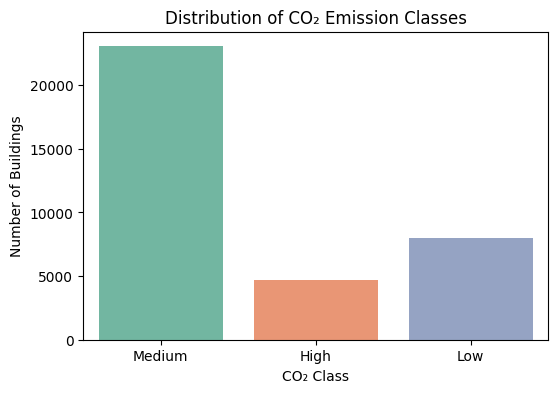

In [ ]:
# Plotting CO2 class count
plt.figure(figsize=(6, 4))
sns.countplot(data=ber_dataset, x="co2_class", hue="co2_class", palette="Set2", legend=False)
plt.title("Distribution of CO₂ Emission Classes")
plt.xlabel("CO₂ Class")
plt.ylabel("Number of Buildings")
plt.show()

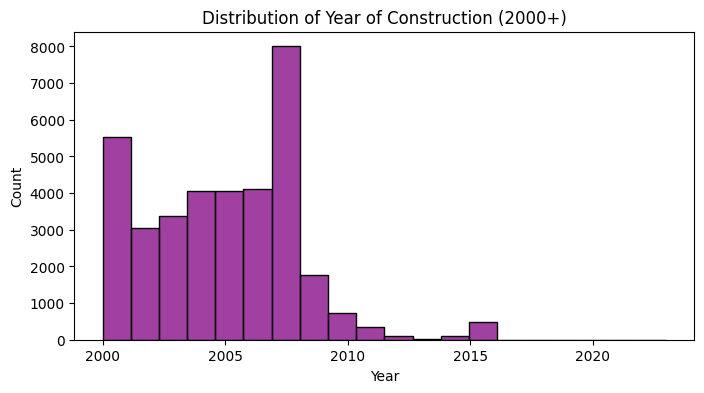

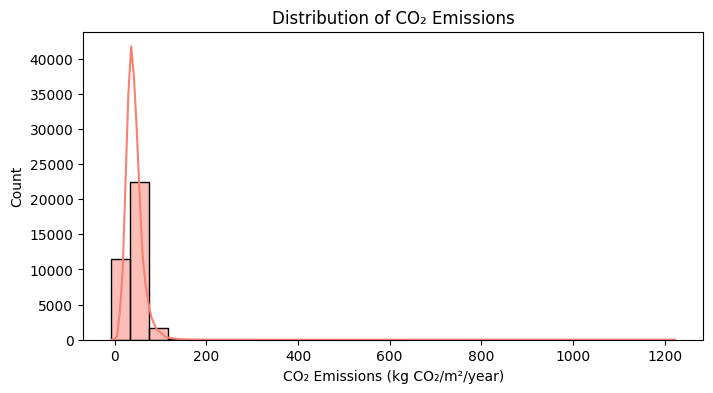

In [ ]:
# Year of Construction Distribution
plt.figure(figsize=(8, 4))
sns.histplot(ber_dataset["year_of_construction"], bins=20, kde=False, color="purple")
plt.title("Distribution of Year of Construction (2000+)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

# Histogram of CO₂ Emissions
plt.figure(figsize=(8, 4))
sns.histplot(ber_dataset["co2rating"], bins=30, kde=True, color="salmon")
plt.title("Distribution of CO₂ Emissions")
plt.xlabel("CO₂ Emissions (kg CO₂/m²/year)")
plt.ylabel("Count")
plt.show()


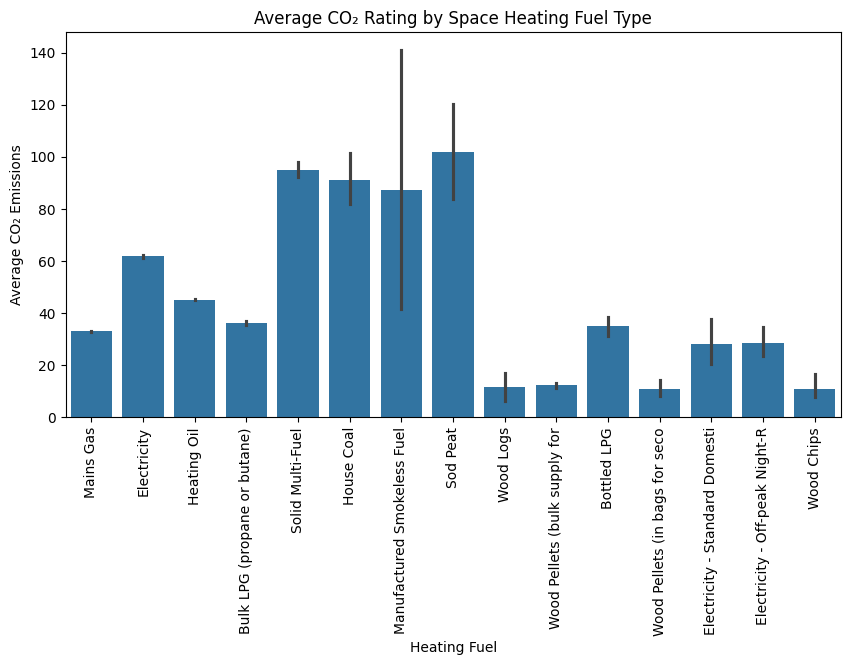

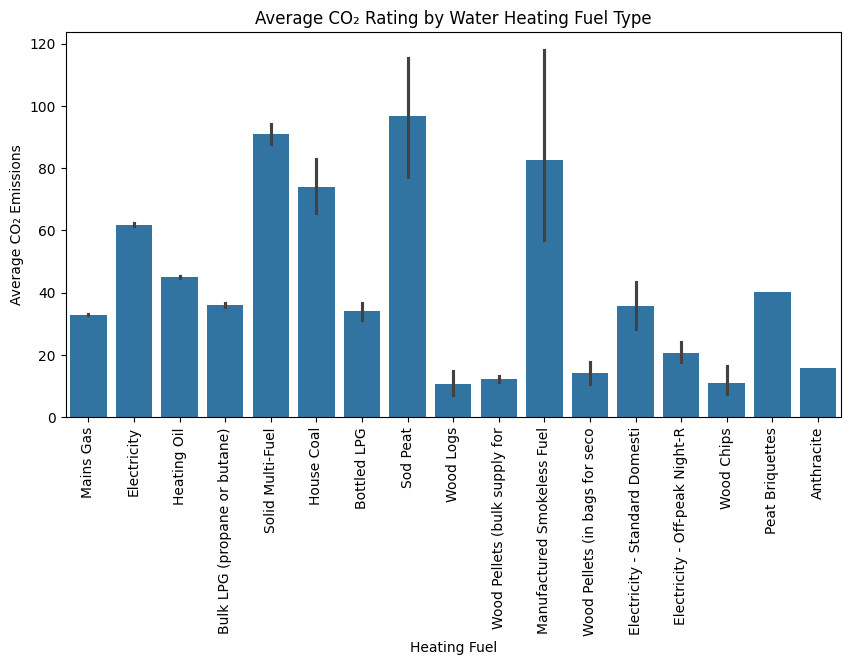

In [ ]:
# Average CO₂ by Heating Fuel Types

# Plot for Main Space Heating Fuel
plt.figure(figsize=(10, 5))
sns.barplot(data=ber_dataset, x="mainspaceheatingfuel", y="co2rating", estimator="mean")
plt.xticks(rotation=90)
plt.title("Average CO₂ Rating by Space Heating Fuel Type")
plt.ylabel("Average CO₂ Emissions")
plt.xlabel("Heating Fuel")
plt.show()

# Plot for Main Water Heating Fuel
plt.figure(figsize=(10, 5))
sns.barplot(data=ber_dataset, x="mainwaterheatingfuel", y="co2rating", estimator="mean")
plt.xticks(rotation=90)
plt.title("Average CO₂ Rating by Water Heating Fuel Type")
plt.ylabel("Average CO₂ Emissions")
plt.xlabel("Heating Fuel")
plt.show()


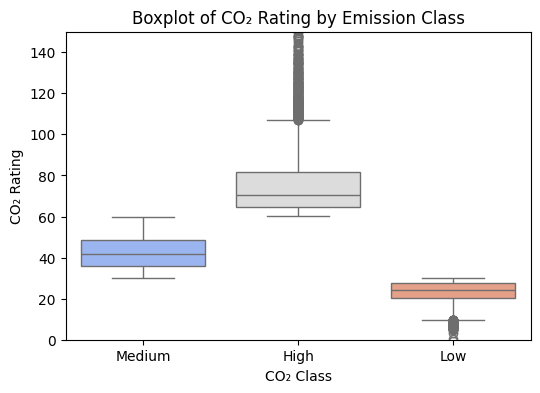

In [ ]:
# Boxplot of CO₂ by class
plt.figure(figsize=(6, 4))
sns.boxplot(data=ber_dataset, x="co2_class", y="co2rating", hue="co2_class", palette="coolwarm", legend=False)
plt.ylim(0, 150)
plt.title("Boxplot of CO₂ Rating by Emission Class")
plt.xlabel("CO₂ Class")
plt.ylabel("CO₂ Rating")
plt.show()


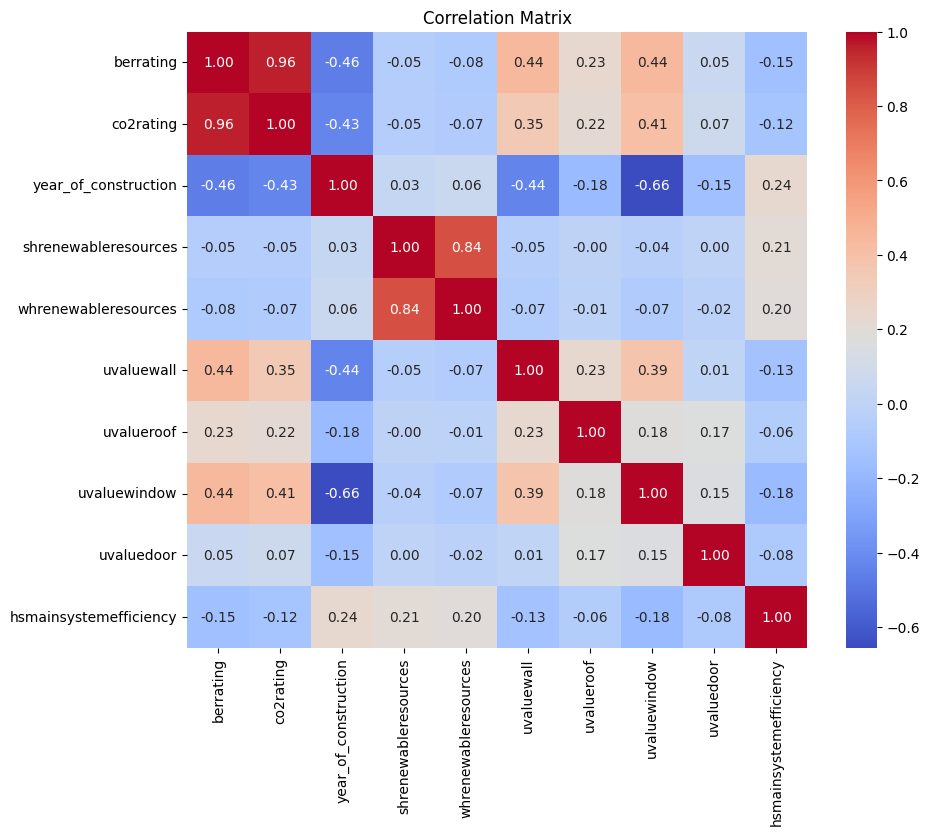

In [ ]:
# Correlation Matrix
numeric_df = ber_dataset.select_dtypes(include=['int64', 'float64'])

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


 ## **Clustering**
 In order to find trends in energy efficiency, clustering was used to group buildings according to structural and insulation-related variables. The business objective of identifying buildings with comparable energy characteristics for focused investment or retrofitting is supported by this unsupervised learning problem.  
 The features were manually selected for clustering
 These variables were chosen because they directly relate to heat loss and building insulation.
 To normalize the data all selected features were scaled using StandardScaler before clustering

In [ ]:
# Selecting features for clustering
selected_features = [
    "year_of_construction",
    "uvaluewall",
    "uvalueroof",
    "uvaluewindow",
    "uvaluedoor"
]

# Drop rows with missing values in selected columns
df_cluster = ber_dataset[selected_features].dropna()

# Scale the selected features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)


## **K-Means & Elbow Method**
K-Means clustering was applied to group buildings based on insulation characteristics and construction year. The number of clusters (K = 5) was chosen after reviewing the elbow method and silhouette scores for different values of K (based on trial and error). A decent balance between pattern separation and simplicity was provided by this value.

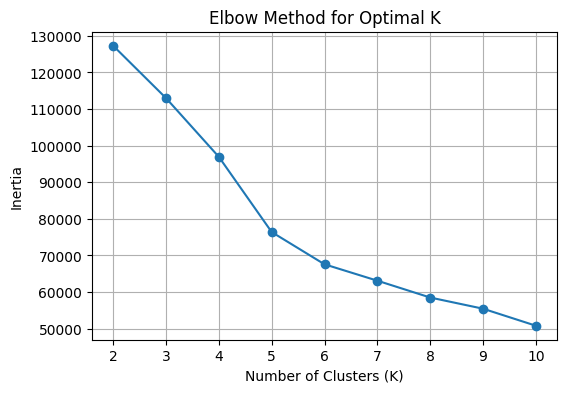

In [ ]:
# Trying different values of K and compute inertia (within-cluster sum of squares)
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.xticks(K_range)
plt.grid(True)
plt.show()


## **Evaluation Metrics**
The Silhouette Score, which compares an object's similarity to its own cluster to other clusters, was computed to evaluate the clustering's quality. With a silhouette score of 0.2900, the model demonstrated reasonable internal cohesiveness and moderate cluster separation.

In [ ]:
# Clustering model and evaluation metrics
kmeans_5 = KMeans(n_clusters=5, random_state=42)
labels_5 = kmeans_5.fit_predict(scaled_data)
silhouette_5 = silhouette_score(scaled_data, labels_5)
print("Silhouette Score for K=5:", silhouette_5)

Silhouette Score for K=5: 0.29004434378555666


## **PCA Visualization**
The multi-dimensional feature space was reduced to two dimensions using Principal Component Analysis (PCA) in order to visualize the resulting clusters. Each data point was colored according to its designated cluster in a scatter plot. The plot showed significant groupings that reflected differences in the buildings construction years and insulation levels.


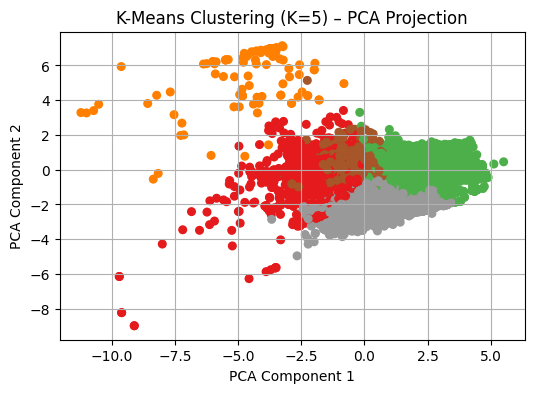

In [ ]:
# Clustering Visualization (PCA Projection)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Plot K=5 Clusters
plt.figure(figsize=(6, 4))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels_5, cmap='Set1', s=30)
plt.title("K-Means Clustering (K=5) – PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

## **Hierarchical Clustering**
Hierarchical clustering was applied as an alternative unsupervised learning method to compare its performance with K-Means and uncover natural groupings within the dataset. Specifically, Agglomerative Clustering was used, which creates clusters from the bottom up by progressively combining the nearest pairs of data points.

In [ ]:
# Reusing the same scaled_data from earlier

# Apply Agglomerative Hierarchical Clustering
agglo_model = AgglomerativeClustering(n_clusters=5, linkage='ward')
agglo_labels = agglo_model.fit_predict(scaled_data)

# Calculate Silhouette Score
silhouette_agglo = silhouette_score(scaled_data, agglo_labels)
print("Silhouette Score (Agglomerative Clustering, K=5):", silhouette_agglo)


Silhouette Score (Agglomerative Clustering, K=5): 0.2664485997038226


## **Evaluation Metrics**
After fitting the Agglomerative Clustering model, the Silhouette Score was calculated to assess clustering quality. The model achieved a silhouette score of 0.2664, indicating moderate structure and separation between clusters.

## **Visualization of cluster**


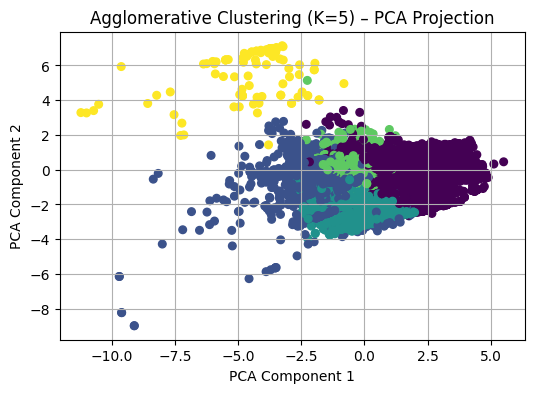

In [ ]:
# Visualize Agglomerative clusters in 2D using the same PCA data from before
plt.figure(figsize=(6, 4))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=agglo_labels, cmap='viridis', s=30)
plt.title("Agglomerative Clustering (K=5) – PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


## **Comparison of Silhouette Scores**
In comparison to other data points, the silhouette score evaluates how well each one fits inside its designated cluster. Clusters that are well-defined and isolated are indicated by a score nearer +1 .

Agglomerative clustering scored 0.2664 in this modelling, whereas K-Means clustering obtained a silhouette score of 0.2900. K-Means performed marginally better in terms of cohesion and separation, despite the fact that both scores show substantial cluster separation.

## **Visual Analysis Employing PCA**
Principal Component Analysis (PCA), which lowers the dimensionality of the dataset, was utilized to visualize the clustering results. While maintaining variance, PCA reduces complex data to principal components.

K-Means clusters were shown to be more compact in the PCA plots, while Agglomerative clusters seemed to be slightly more overlapped. This offered a visual representation of clustering quality and supported the numerical silhouette evaluation.

## **Cluster Structure and Suitability**
K-Means performs well with structured data since it assumes that clusters are spherical and comparable in size. Agglomerative clustering, on the other hand, is more appropriate for data with nested categories or variable forms and does not enforce such assumptions.

Both models generated significant segments based on the building dataset's features, including varying insulation and construction years. Overall, though, K-Means provided better-defined clusters.



## **Classification**
In this phase of the project, supervised machine learning was used to build a classification model that predicts a building’s CO₂ emission class (Low, Medium, or High) based on structural and heating-related features.  
In this step, we will use `co2_class` as our target variable for classification, along with a specific set of features defined based on their relevance.


In [ ]:
# Update features and target
selected_features = [
    'year_of_construction',
    'uvaluewall',
    'uvalueroof',
    'uvaluewindow',
    'mainspaceheatingfuel',
    'mainwaterheatingfuel'
]

target = 'co2_class'

X = ber_dataset[selected_features]
y = ber_dataset[target]

# Display updated shapes
print("Updated Features shape:", X.shape)
print("Updated Target shape:", y.shape)

Updated Features shape: (35722, 6)
Updated Target shape: (35722,)


Now, we will encode the categorical features (`mainspaceheatingfuel`, `mainwaterheatingfuel`) using `OneHotEncoder` and scale numerical features (`year_of_construction`, `uvaluewall`, `uvalueroof`, `uvaluewindow`) with `StandardScaler`.

In [ ]:
# Identify categorical and numerical columns
categorical_features = ['mainspaceheatingfuel', 'mainwaterheatingfuel']
numerical_features = ['year_of_construction', 'uvaluewall', 'uvalueroof', 'uvaluewindow']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Check processed feature shape
print("Processed features shape (updated):", X_processed.shape)

Processed features shape (updated): (35722, 36)


After encoding categorical variables and scaling numerical variables, the processed features expanded from 6 to 36, indicating categorical encoding was done successfully.

Then, we split our dataset into training and testing sets to evaluate model performance effectively.

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)

# Verify shapes
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (25005, 36)
Testing set shape: (10717, 36)


The dataset has been split into approximately 70% training and 30% testing sets. Both sets have identical feature dimensions (36), confirming the data split is performed correctly and is ready for modeling.

Now, we will train two classifiers:

- **Random Forest (Ensemble method)**
- **Logistic Regression (Baseline method)**

Here, we will use reasonable initial hyperparameters for both models:

- Random Forest with `n_estimators` = 100
- Logistic Regression with `max_iter` = 1000

In [ ]:
# Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Logistic Regression classifier
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
log_predictions = log_model.predict(X_test)

We evaluate both models using classification metrics: accuracy, precision, recall, and F1-score.

In [ ]:
# Random Forest evaluation
print("Random Forest Classifier Performance:\n")
print(classification_report(y_test, rf_predictions))

# Logistic Regression evaluation
print("\nLogistic Regression Classifier Performance:\n")
print(classification_report(y_test, log_predictions))

Random Forest Classifier Performance:

              precision    recall  f1-score   support

        High       0.67      0.61      0.64      1411
         Low       0.81      0.73      0.76      2391
      Medium       0.84      0.88      0.86      6915

    accuracy                           0.81     10717
   macro avg       0.77      0.74      0.75     10717
weighted avg       0.81      0.81      0.81     10717


Logistic Regression Classifier Performance:

              precision    recall  f1-score   support

        High       0.69      0.61      0.65      1411
         Low       0.75      0.64      0.69      2391
      Medium       0.81      0.87      0.84      6915

    accuracy                           0.79     10717
   macro avg       0.75      0.71      0.73     10717
weighted avg       0.78      0.79      0.78     10717



- The **Random Forest** classifier (accuracy ~81%) clearly outperforms **Logistic Regression** (accuracy ~79%), demonstrating good but realistic predictive power.
- *Medium* class has the highest precision and recall, meaning the model performs well identifying majority cases.

Now, we visualize the confusion matrix for the **Random Forest** model to understand its accuracy in predicting each class.

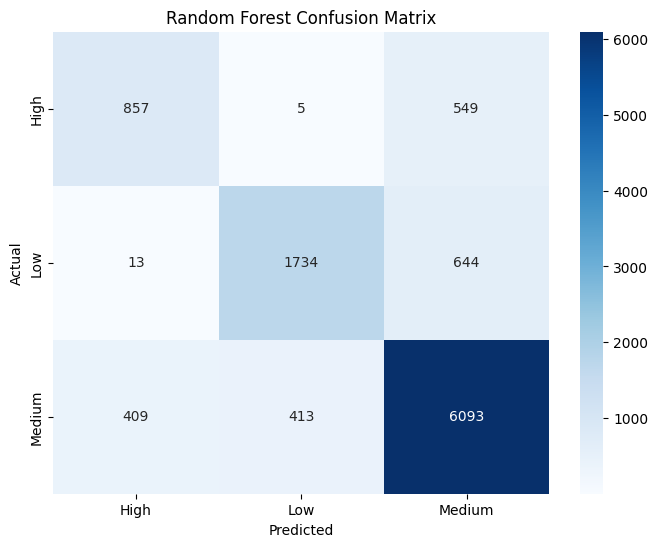

In [ ]:
# Confusion matrix for Random Forest
cm = confusion_matrix(y_test, rf_predictions)

# Extract unique labels for ordering
labels = sorted(y.unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The Confusion Matrix visualization clearly represents the performance of our **Random Forest** model:
- In *High* class, we have 857 correct predictions, 549 classified as *Medium*, and 5 as *Low*, indicating moderate accuracy.
- In *Medium* class, we have 6093 correct predictions, 413 misclassified as *Low*, and 409 as *High*, indicating strong accuracy and good identification of majority class.
- In *Low* class, 1734 out of 2118 instances were correctly predicted, 644 misclassified as *Medium*, and 13 as *High*, indicating reasonably good accuracy.

The Confusion Matrix visually confirms the accuracy score (~81), ensuring the model’s integrity.

Furthermore, we examine feature importances from our ensemble model (Random Forest) to identify top features affecting `co2_class` predictions.

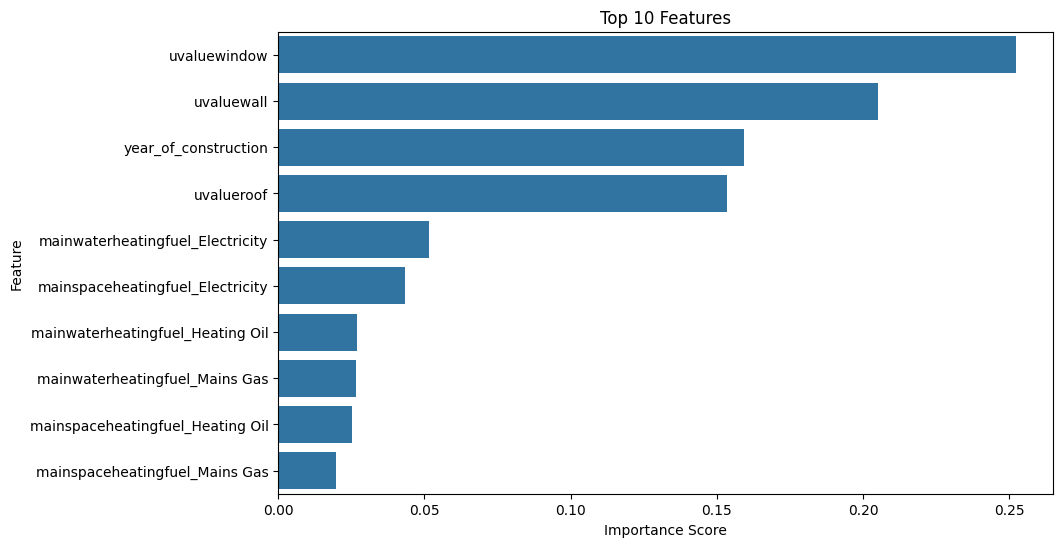

In [ ]:
# Get feature names after encoding
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Get feature importances
importances = rf_model.feature_importances_

# Sort importances
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:10], y=np.array(feature_names)[indices][:10])
plt.title('Top 10 Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

The **feature importance plot** from our Random Forest model clearly shows the top 10 most influential features for classifying the energy ratings:

- **insulation efficiency**(U-values for windows, walls, roofs) and **constructionyear** are key physical determinants of energy performance and CO₂ output.
- **Heating fuel types** also contribute, though to a lesser degree, aligning well with energy consumption patterns.

## **Insights and Recommendations**

Our objective was to examine the energy performance of residential buildings in Ireland using machine learning models—clustering and classification—to identify patterns in insulation and predict CO₂ emission classes.

In Ireland’s growing property market, the demand for energy-efficient homes is rising. However, the current methods of manual audits are resource intensive and not scalable. Investors, government agencies, and energy consultants need a faster way to determine which properties are environmentally efficient.

Our project uses open building performance data and machine learning to provide **scalable alternatives** that predicts CO₂ emissions and identifies key structural indicators that influence them. This allows for better targeting of **retrofitting programs** and **green investment strategies**.



### Key Insights from Analysis

1. **Thermal Envelope is the Most Critical Factor**
- Features like U-value of windows, walls, and roofs were consistently the top predictors of CO₂ emission class. These indicate the quality of insulation.
- Lower U-values (i.e., better insulation) strongly correlate with lower CO₂ emissions.

2. **Year of Construction Impacts Efficiency**
- Older homes are more likely to fall into high CO₂ emission categories, affirming that building regulations over time have improved energy standards.

3. **Heating Fuel Type Matters**
- Buildings using electricity for space and water heating performed better in emission classification compared to those using oil or gas.
- This highlights a key area for promoting cleaner energy resources to reduce carbon footprint.

4. **Model Performance**
- The **Random Forest classifier** achieved an accuracy of **81%**, successfully distinguishing among high, medium, and low CO₂ classes.
- Based on insulation properties and construction era, the clustering analysis (using both K-Means and Agglomerative Clustering) identified naturally occurring building groupings. Using silhouette scores, **K-Means** showed somewhat better cluster separation than the other, which made it more successful in recognizing different energy-efficiency profiles. In order to facilitate more effective policy formulation and focused outreach, these clusters can assist in identifying groups of homes that might profit from comparable retrofitting techniques.


### Recommendations

1. **Operational Use by Retrofit Programs**
- The model can be integrated into public-sector dashboards to identify high-emission homes and prioritize them for grant-supported retrofitting (e.g., insulation upgrades).
- Homes built before 2000 can be automatically flagged with high U-values for targeted outreach.

2. **Investor & Property Market Integration**
- The model can be used by real estate firms or green investors to score buildings for energy performance and estimate sustainability risk before acquisition.
- CO₂ emission class predictions can be embedded into listings on property platforms, allowing buyers to filter properties by environmental impact.

3. **Consumer-Facing Applications**
- The model can be used by utility companies or energy advisors to generate personalized retrofit suggestions for homeowners.
- Simulated CO₂ class improvements can be offered when users input planned insulation or heating upgrades.



### How the Model Can Be Deployed

- The combination of `StandardScaler` and `OneHotEncoder` is portable and can be reused across systems.
- The Random Forest classifier can be saved using `joblib` or `pickle` and integrated into web or mobile applications.
- Cloud-based APIs (via AWS Lambda, Google Cloud Functions, or Azure ML) can allow real-time classification at scale.
- With only 6 core input fields (year, U-values, and heating types), the system is lightweight and easy to integrate into forms or existing databases.





## **Conclusion**

The project shows how open residential building data with machine learning can help make better climate decisions in housing. It supports both macro-level strategies (e.g., national retrofit plans) and micro-level decisions (e.g., home purchase choices), which is in line with Ireland’s transition to a low-carbon future.